# Twitter Sentimental Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk
%matplotlib inline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
df1= pd.read_csv('./subsetData.csv', encoding='latin-1')



In [3]:
df1.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df1.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [5]:
df1.columns = ['sentiments','1', '2', '3',
       '4',
       'text']

In [6]:
df1.head()

,sentiments,1,2,3,4,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
df1.drop(['1', '2', '3','4'], axis=1, inplace=True)

In [8]:
df2 = df1.copy()

In [9]:
df2.shape

(13366, 2)

In [10]:
df2.sentiments.value_counts()

0    12866
4      500
Name: sentiments, dtype: int64

In [11]:
df2['letter_Count'] = df2['text'].str.len()

#### Sentiments - 4 stands for positive tweet and 0 stands for negative tweet

In [12]:
df2.head()

#Sentiments - 4 stands for positive tweet and 0 stands for negative tweet

,sentiments,text,letter_Count
0,0,is upset that he can't update his Facebook by ...,111
1,0,@Kenichan I dived many times for the ball. Man...,89
2,0,my whole body feels itchy and like its on fire,47
3,0,"@nationwideclass no, it's not behaving at all....",111
4,0,@Kwesidei not the whole crew,29


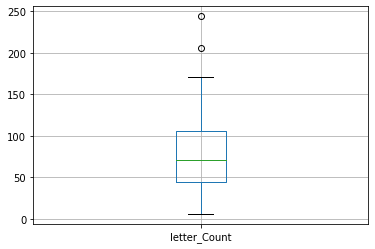

In [13]:
#df2.letter_Count.box_plot()
boxplot = df2.boxplot(column=['letter_Count'])


Text(0.5, 1.0, 'Count of Possitive : (4) and Negative Sentiments : (0)')

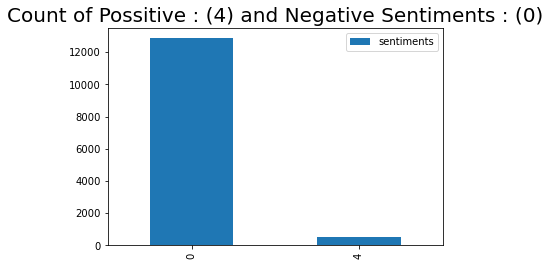

In [115]:
df2["sentiments"].value_counts().plot.bar()
plt.legend()
plt.title('Count of Possitive : (4) and Negative Sentiments : (0)', size=20)

In [15]:
#tweets >140 characters

In [16]:
#df2.letter_Count>140
df2[df2['letter_Count']>140]

,sentiments,text,letter_Count
212,0,Awwh babs... you look so sad underneith that s...,142
225,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
278,0,Whinging. My client&amp;boss don't understand ...,145
342,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
399,0,#3 woke up and was having an accident - &quot;...,144
...,...,...,...
12809,0,"@brandonbeemer Hi Brandon, Just wanted to say ...",146
12845,0,rt @Whoopsie. Gullible sales monkey didn't get...,145
12936,0,I really wish i could go to Aikido of Modesto'...,148
13056,0,OMG just watched &quot;The Strangers&quot; its...,141


### Data Cleaning

In [105]:
df2.shape

(13366, 3)

In [17]:
from bs4 import BeautifulSoup

In [18]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()



In [19]:
testing = df2.text[:100]

test_result = []

for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

['is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut not out now',
 'about to 

In [106]:
nums = [0,13366]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%100 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                 
    clean_tweet_texts.append(tweet_cleaner(df2['text'][i]))
    

Cleaning and parsing the tweets...

Tweets 100 of 13366 has been processed
Tweets 200 of 13366 has been processed
Tweets 300 of 13366 has been processed
Tweets 400 of 13366 has been processed
Tweets 500 of 13366 has been processed
Tweets 600 of 13366 has been processed
Tweets 700 of 13366 has been processed
Tweets 800 of 13366 has been processed
Tweets 900 of 13366 has been processed
Tweets 1000 of 13366 has been processed
Tweets 1100 of 13366 has been processed
Tweets 1200 of 13366 has been processed
Tweets 1300 of 13366 has been processed
Tweets 1400 of 13366 has been processed
Tweets 1500 of 13366 has been processed
Tweets 1600 of 13366 has been processed
Tweets 1700 of 13366 has been processed
Tweets 1800 of 13366 has been processed
Tweets 1900 of 13366 has been processed
Tweets 2000 of 13366 has been processed
Tweets 2100 of 13366 has been processed
Tweets 2200 of 13366 has been processed
Tweets 2300 of 13366 has been processed
Tweets 2400 of 13366 has been processed
Tweets 2500 o

In [21]:
clean_tweet_texts

['is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut not out now',
 'about to 

In [22]:
clean_tweet_texts = pd.DataFrame(clean_tweet_texts)
clean_tweet_texts.to_csv('./cleaneData.csv')

In [23]:
clean_tweet_texts.tail()

,0
13361,ugh my right click keeps doing things i don t ...
13362,had birthday cake with summer feel sick now
13363,got a horrible mermaid damnit skye
13364,oh you won t be there well me and swoopy might...
13365,listening to chente damn i miss my daddy


In [24]:
clean_tweet_texts['sentiments'] = df1['sentiments']

In [25]:
clean_tweet_texts.columns = ['text', 'sentiments']

#### Tokenize

In [26]:
from nltk.tokenize import word_tokenize # import word_tokenize

word_token = []
for words in clean_tweet_texts['text']:
    word_token.append(word_tokenize(words))

In [27]:
word_token

[['is',
  'upset',
  'that',
  'he',
  'can',
  't',
  'update',
  'his',
  'facebook',
  'by',
  'texting',
  'it',
  'and',
  'might',
  'cry',
  'as',
  'a',
  'result',
  'school',
  'today',
  'also',
  'blah'],
 ['i',
  'dived',
  'many',
  'times',
  'for',
  'the',
  'ball',
  'managed',
  'to',
  'save',
  'the',
  'rest',
  'go',
  'out',
  'of',
  'bounds'],
 ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'],
 ['no',
  'it',
  's',
  'not',
  'behaving',
  'at',
  'all',
  'i',
  'm',
  'mad',
  'why',
  'am',
  'i',
  'here',
  'because',
  'i',
  'can',
  't',
  'see',
  'you',
  'all',
  'over',
  'there'],
 ['not', 'the', 'whole', 'crew'],
 ['need', 'a', 'hug'],
 ['hey',
  'long',
  'time',
  'no',
  'see',
  'yes',
  'rains',
  'a',
  'bit',
  'only',
  'a',
  'bit',
  'lol',
  'i',
  'm',
  'fine',
  'thanks',
  'how',
  's',
  'you'],
 ['k', 'nope', 'they', 'didn', 't', 'have', 'it'],
 ['que', 'me', 'muera'],
 ['spring', 'break', 'in', 'pla

#### Lemmatize

In [28]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df3 = []
for lemit_word in word_token:
    b=[lemmatizer.lemmatize(q) for q in lemit_word]
    df3.append(b)
    
    


In [29]:
df3

[['is',
  'upset',
  'that',
  'he',
  'can',
  't',
  'update',
  'his',
  'facebook',
  'by',
  'texting',
  'it',
  'and',
  'might',
  'cry',
  'a',
  'a',
  'result',
  'school',
  'today',
  'also',
  'blah'],
 ['i',
  'dived',
  'many',
  'time',
  'for',
  'the',
  'ball',
  'managed',
  'to',
  'save',
  'the',
  'rest',
  'go',
  'out',
  'of',
  'bound'],
 ['my', 'whole', 'body', 'feel', 'itchy', 'and', 'like', 'it', 'on', 'fire'],
 ['no',
  'it',
  's',
  'not',
  'behaving',
  'at',
  'all',
  'i',
  'm',
  'mad',
  'why',
  'am',
  'i',
  'here',
  'because',
  'i',
  'can',
  't',
  'see',
  'you',
  'all',
  'over',
  'there'],
 ['not', 'the', 'whole', 'crew'],
 ['need', 'a', 'hug'],
 ['hey',
  'long',
  'time',
  'no',
  'see',
  'yes',
  'rain',
  'a',
  'bit',
  'only',
  'a',
  'bit',
  'lol',
  'i',
  'm',
  'fine',
  'thanks',
  'how',
  's',
  'you'],
 ['k', 'nope', 'they', 'didn', 't', 'have', 'it'],
 ['que', 'me', 'muera'],
 ['spring', 'break', 'in', 'plain', '

#### Initialize list clean_df3 to join word tokens after lemmatization

In [30]:
clean_df3 =[] 
for c in df3:  # for loop for each list in df1
    a = " ".join(c) # join words in list with space in between and giev it to a
    clean_df3.append(a) # append a to clean_df1

In [31]:
clean_df3

['is upset that he can t update his facebook by texting it and might cry a a result school today also blah',
 'i dived many time for the ball managed to save the rest go out of bound',
 'my whole body feel itchy and like it on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rain a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ear',
 'i couldn t bear to watch it and i thought the ua loss wa embarrassing',
 'it it count idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how wa the premiere',
 'hollis death scene will hurt me severely to watch on film wry is director cut not out now',
 'about to file tax',


In [32]:
clean_df = pd.DataFrame(clean_df3)
clean_df['target'] = df1['sentiments']

In [33]:
clean_df.columns = ['text', 'target']
clean_df

,text,target
0,is upset that he can t update his facebook by ...,0
1,i dived many time for the ball managed to save...,0
2,my whole body feel itchy and like it on fire,0
3,no it s not behaving at all i m mad why am i h...,0
4,not the whole crew,0
...,...,...
13361,ugh my right click keep doing thing i don t wa...,0
13362,had birthday cake with summer feel sick now,0
13363,got a horrible mermaid damnit skye,0
13364,oh you won t be there well me and swoopy might...,0


In [34]:
clean_df['letter_Count'] = clean_df['text'].str.len()

In [35]:
clean_df['letter_Count'].unique()

array([104,  71,  44,  88,  18,  10,  76,  26,  12,  39,  24,  69,  61,
        99,  68,  89,  17,  53,  58,  48,  95,  40,  36,  23,  45,  62,
        21,  78,  72, 119, 126,  37, 124,  85,  28,  86,  87,  96,  81,
       105,  77, 133,  49,  59, 107,  55, 116, 132,  19, 101,  83,  31,
        98,  65,  54, 118,  92, 123,  30,  22,  35,  91,  14,  52, 125,
       113, 109, 100,  27,  74,  60,  41,  20,  56, 102,  46, 122,  11,
       128,   8, 108,  75,  29, 120,  43,  13,  33,  16,  66,  90,  42,
        63,  94,  67, 103,  38, 111, 131,   5,  25,  64,  32,  84,   0,
       112,  70, 117,  47,  80,  50,  73, 115,  82,  57, 130,   7, 127,
        97,  79, 114,  15, 106,  34, 121,  51, 110,  93,   9,   6,   4,
       129,   3, 135, 136, 134,   1, 138,   2], dtype=int64)

In [36]:
clean_df[clean_df['letter_Count']>100]

,text,target,letter_Count
0,is upset that he can t update his facebook by ...,0,104
30,i want to go to promote gear and groove but un...,0,119
31,thought sleeping in wa an option tomorrow but ...,0,126
34,ok i m sick and spent an hour sitting in the s...,0,124
43,falling asleep just heard about that tracy gir...,0,105
...,...,...,...
13351,but i had to pick k up from school even earlie...,0,109
13357,i do like the carrot to get people to join the...,0,104
13359,for some reason my phone didnt send me any of ...,0,108
13361,ugh my right click keep doing thing i don t wa...,0,122


In [37]:
X = clean_df.text # get all the text in x variable
y = clean_df.target # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y

(13366,)
(13366,)


#### Training and Testing Sets

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) 

#### Tf-Idf Vectorizer

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS

In [116]:
stopwords = set(STOPWORDS)
stopwords.remove("not")

In [41]:
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))

In [42]:
vect.fit(X_train)
vect_Xtrn_trnfm = vect.transform(X_train)

In [43]:
vect_Xtest_trnfm = vect.transform(X_test)

In [44]:
#vect_Xtest_trnfm.get_feature_names()

In [45]:
#vect.get_feature_names()


#### MultinomialNB - Naive Bayes classifier for multinomial models

In [46]:
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive Bayes model from sklearn.naive_bayes
nb = MultinomialNB(alpha = 10) # get object of Multinomial naive bayes model with alpha parameter = 10

In [47]:
nb.fit(vect_Xtrn_trnfm, y_train)
# fit our both traing data tweets as well as its sentiments to the multinomial naive bayes model

MultinomialNB(alpha=10)

In [48]:
prediction= {}

In [49]:

prediction['Multinomial'] = nb.predict_proba(vect_Xtest_trnfm)[:,1]


In [50]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = nb, X = vect_Xtrn_trnfm, y = y_train, cv = 4) 


In [51]:
acc3 =accuracies.mean() # measure the mean accuray of 10 fold cross validation

In [52]:
y_predNb = nb.predict(vect_Xtest_trnfm)

In [53]:
y_predNb

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score # import cross_val_score from sklear.model_selection


In [55]:
logisticRegr = LogisticRegression(solver='lbfgs' , C=1000)

In [56]:
accuracies = cross_val_score(estimator = logisticRegr, X = vect_Xtrn_trnfm, y = y_train, cv = 4) # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

0.9641788252899366

In [57]:
logisticRegr.fit(vect_Xtrn_trnfm, y_train)

C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1000)

In [58]:
prediction['LogisticRegression'] = logisticRegr.predict_proba(vect_Xtest_trnfm)[:,1]

In [59]:
y_pred_lg = logisticRegr.predict(vect_Xtest_trnfm)  # predict the sentiments of testing data tweets

In [60]:
for i in vect_Xtest_trnfm:
    print(i)

  (0, 170195)	0.18165554922853414
  (0, 170188)	0.16347184477508428
  (0, 151339)	0.23001122090851886
  (0, 149342)	0.0519606494415419
  (0, 114371)	0.23001122090851886
  (0, 114362)	0.1772800129120818
  (0, 105899)	0.220280460943659
  (0, 105848)	0.0806279996367003
  (0, 92928)	0.12347645944906452
  (0, 88531)	0.23001122090851886
  (0, 74784)	0.220280460943659
  (0, 70364)	0.16423378200795097
  (0, 70351)	0.1537410848102244
  (0, 69939)	0.23001122090851886
  (0, 69936)	0.1870107728769417
  (0, 69837)	0.14144723800424386
  (0, 66033)	0.220280460943659
  (0, 65880)	0.11310310077447287
  (0, 65643)	0.18165554922853414
  (0, 65639)	0.17475146516003537
  (0, 63245)	0.20802115322675266
  (0, 63065)	0.10976094944669199
  (0, 52625)	0.10944307715729586
  (0, 52490)	0.10100987681378736
  (0, 37554)	0.16667646560045027
  (0, 29980)	0.17475146516003537
  (0, 16658)	0.23001122090851886
  (0, 16647)	0.18165554922853414
  (0, 12824)	0.17246411548841797
  (0, 12647)	0.10328056629244628
  (0, 10691)	

  (0, 5147)	0.0611925967256673
  (0, 170046)	0.20066687173619474
  (0, 167414)	0.3560123068846157
  (0, 167253)	0.2092403520048873
  (0, 159608)	0.3001422073569353
  (0, 159226)	0.248647248323287
  (0, 158053)	0.26219219427613827
  (0, 139868)	0.2575432424359592
  (0, 130240)	0.2068207030538057
  (0, 86845)	0.11962077721012603
  (0, 71399)	0.2315775702378452
  (0, 69837)	0.1094663062641982
  (0, 49662)	0.22905824828287544
  (0, 46822)	0.18804702904430473
  (0, 45695)	0.11550605944462829
  (0, 36604)	0.2126025636974467
  (0, 36556)	0.30451734785096757
  (0, 36243)	0.1554934452576627
  (0, 29005)	0.34095099687918756
  (0, 175849)	0.44427558763286173
  (0, 154371)	0.2242714875960554
  (0, 138369)	0.17913981005386284
  (0, 82629)	0.2558575396646839
  (0, 38043)	0.5046814502579187
  (0, 38017)	0.37627369640521685
  (0, 34713)	0.4665695942376202
  (0, 14109)	0.20197748099129692
  (0, 173282)	0.2723632535148427
  (0, 167607)	0.36633324218495283
  (0, 167555)	0.2257114455367223
  (0, 153688)	0

  (0, 139868)	0.11212088393642604
  (0, 114778)	0.31391851652917757
  (0, 86172)	0.4313401977937247
  (0, 83456)	0.2771601705939919
  (0, 71876)	0.12694939002660982
  (0, 70664)	0.4313401977937247
  (0, 69837)	0.14296774673848436
  (0, 64587)	0.22335938040501777
  (0, 34728)	0.4649675234644324
  (0, 18334)	0.37056368522713706
  (0, 169965)	0.1476217558643715
  (0, 169960)	0.14697692694512293
  (0, 163659)	0.12649484495211272
  (0, 158525)	0.09567611460692758
  (0, 151260)	0.23792307748872707
  (0, 151237)	0.1623442766660108
  (0, 149342)	0.053747976184003135
  (0, 148524)	0.23792307748872707
  (0, 148516)	0.19145649141444054
  (0, 148504)	0.10500702480783423
  (0, 135763)	0.143424517534349
  (0, 106844)	0.20682384113532845
  (0, 105848)	0.08340141724195864
  (0, 101753)	0.1863019443501512
  (0, 101670)	0.09472729143678191
  (0, 92950)	0.20350898872967652
  (0, 92928)	0.06386188272357755
  (0, 85532)	0.22071603310920176
  (0, 85349)	0.12146262944348311
  (0, 80007)	0.21517660209345893
 

  (0, 166497)	0.3143635659473975
  (0, 166496)	0.3143635659473975
  (0, 166443)	0.15286773023935504
  (0, 162473)	0.2505373292109567
  (0, 134720)	0.20017820431279304
  (0, 125278)	0.20120329390455927
  (0, 81389)	0.3143635659473975
  (0, 80731)	0.1315335159478875
  (0, 63996)	0.22553898516517223
  (0, 60536)	0.2916282016958192
  (0, 48147)	0.17318938187663468
  (0, 42972)	0.1929601310830243
  (0, 42871)	0.1502331400411629
  (0, 33652)	0.3143635659473975
  (0, 33635)	0.16658720212543793
  (0, 15415)	0.3143635659473975
  (0, 15400)	0.2615736849441601
  (0, 172097)	0.18203380596201982
  (0, 164887)	0.1208183780039543
  (0, 153091)	0.2038130439742238
  (0, 149342)	0.04807624827091165
  (0, 147335)	0.21281636546776225
  (0, 147314)	0.13324460346920042
  (0, 145830)	0.2038130439742238
  (0, 145743)	0.11217034285754572
  (0, 143892)	0.15343710069049327
  (0, 139868)	0.10263580920489065
  (0, 138730)	0.18499886024964493
  (0, 138369)	0.07234470370445158
  (0, 136425)	0.197425085714891
  (0, 1

  (0, 4031)	0.19177880803482372
  (0, 120955)	0.14259182604549325
  (0, 111040)	0.2783145621897736
  (0, 111039)	0.2486738800625998
  (0, 102124)	0.2738538980277581
  (0, 101670)	0.1274707233891891
  (0, 100426)	0.3201635593973492
  (0, 100342)	0.11199922427551944
  (0, 31675)	0.1825656421842775
  (0, 31667)	0.17753278155412033
  (0, 24503)	0.18123457528857587
  (0, 23549)	0.3201635593973492
  (0, 23546)	0.24676448270545215
  (0, 23127)	0.1231670150025373
  (0, 16509)	0.2970087287125536
  (0, 16508)	0.2970087287125536
  (0, 16497)	0.20438940597337144
  (0, 11907)	0.3201635593973492
  (0, 11845)	0.19263150705692395
  (0, 168773)	0.21636262721880084
  (0, 168590)	0.10836531408585537
  (0, 161808)	0.22592031918028213
  (0, 161066)	0.08730340312654788
  (0, 151249)	0.20958133685287078
  (0, 151237)	0.15415432243311902
  (0, 149342)	0.051036494916553536
  (0, 145093)	0.16545890002192382
  (0, 144766)	0.10673363967897372
  (0, 137159)	0.1728524889374143
  (0, 130240)	0.13124546074231583
  (0

  (0, 173530)	0.2659983804668749
  (0, 165163)	0.22246924804035478
  (0, 123819)	0.4169485617782252
  (0, 123797)	0.3152301149791036
  (0, 74222)	0.39793414963113355
  (0, 71876)	0.12271373236475111
  (0, 59512)	0.4494539140420887
  (0, 59508)	0.3907052056347788
  (0, 59445)	0.28011879729015043
  (0, 149919)	0.3426101396410173
  (0, 149342)	0.07739729083949783
  (0, 132109)	0.28884328318473196
  (0, 129797)	0.16874619331358648
  (0, 67091)	0.10699946805441655
  (0, 59458)	0.3281158162023368
  (0, 59448)	0.26610833829337516
  (0, 59445)	0.2135292123558303
  (0, 58265)	0.11888056838289335
  (0, 55227)	0.20653185264349594
  (0, 42201)	0.3426101396410173
  (0, 34583)	0.30985512825763006
  (0, 26254)	0.24349730132531985
  (0, 15955)	0.2816698275493892
  (0, 15620)	0.16847121195702944
  (0, 12113)	0.3033376066234124
  (0, 80777)	0.5066848666089866
  (0, 80731)	0.22136818409046607
  (0, 37554)	0.3833859906495376
  (0, 36433)	0.38747690284837333
  (0, 36243)	0.23107770996448396
  (0, 13142)	0.

In [61]:
y_pred_lg

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [62]:
a= np.column_stack((X_test, y_test))
b = np.column_stack((a,y_pred_lg))
to_df = pd.DataFrame(b)

to_df.to_csv('./logistic_testdata.csv')

In [63]:
from sklearn import metrics # import metrics from sklearn
acc1 = metrics.accuracy_score(y_test, y_pred_lg) # measure the accuracy of our model on the testing data

In [64]:
from sklearn.metrics import confusion_matrix # import confusion matrix from the sklearn.metrics
confusion_matrix(y_test, y_pred_lg) # plot the confusion matrix between our predicted sentiments and the original testing data sentiments

array([[2561,    3],
       [ 100,   10]], dtype=int64)

#### Linear CV

In [65]:
from sklearn.svm import LinearSVC # import SVC model from sklearn.svm
svm_clf = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0

In [66]:
svm_clf.fit(vect_Xtrn_trnfm, y_train)# fit our both traing data tweets as well as its sentiments to the SVC model

LinearSVC(random_state=0)

In [67]:
accuracies = cross_val_score(estimator = svm_clf, X = vect_Xtrn_trnfm, y = y_train, cv = 4)
# do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

0.9639917695473252

In [68]:
y_pred_svm = svm_clf.predict(vect_Xtest_trnfm)  # predict the sentiments of testing data tweets

In [69]:
acc = metrics.accuracy_score(y_test, y_pred_svm)  # measure the accuracy of our model on the testing data

In [70]:
confusion_matrix(y_test, y_pred_svm)# plot the confusion matrix between our predicted sentiments and the original testing data sentiments

array([[2561,    3],
       [ 102,    8]], dtype=int64)

In [112]:
accTable = {'SVC':[acc], 'Logistic':[acc1], 'Multinomail NB':[acc3] }
accTable

{'SVC': 0.9607329842931938,
 'Logistic': 0.9614809274495139,
 'Multinomail NB': 0.9635241301907969}

In [114]:
 pd.DataFrame({'SVC':[acc], 'Logistic':[acc1], 'Multinomail NB':[acc3]})

,SVC,Logistic,Multinomail NB
0,0.960733,0.961481,0.963524


In [73]:
prediction.items()


dict_items([('Multinomial', array([0.00408442, 0.00561428, 0.00314257, ..., 0.00334265, 0.01855622,
       0.00370754])), ('LogisticRegression', array([3.80414111e-04, 3.82807440e-04, 5.31349871e-06, ...,
       1.28107017e-05, 3.93085264e-04, 5.46207360e-07]))])

In [75]:
tTrain = y_train.copy()
tTest = y_test.copy()

train = pd.Series(tTrain)
test = pd.Series(tTest)

Trainresult = train.replace(to_replace = 4, value = 1)
Testresult = test.replace(to_replace = 4, value = 1)

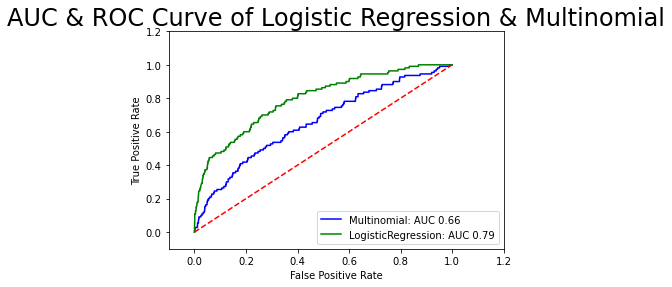

In [78]:
#AUC & ROC Curve of Logistic Regression & Multinomial

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    if model not in 'Naive':
        false_positive_rate, true_positive_rate, thresholds = roc_curve(Testresult, predicted)
        roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC & ROC Curve of Logistic Regression & Multinomial', size=24)
plt.show()

In [79]:
tTrain = y_train.copy()
tTest = y_test.copy()

In [80]:
train = pd.Series(tTrain)
test = pd.Series(tTest)

Trainresult = train.replace(to_replace = 4, value = 1)
Testresult = test.replace(to_replace = 4, value = 1)

#### Precision, Recall, f1-Score, Support

In [81]:
keys = prediction.keys()
for key in ['Multinomial', 'LogisticRegression']:
    print(" {}:".format(key))
    print(metrics.classification_report(Testresult, prediction.get(key)>.5, target_names = ["positive", "negative"]))
    print("\n")

 Multinomial:
              precision    recall  f1-score   support

    positive       0.96      1.00      0.98      2564
    negative       0.00      0.00      0.00       110

    accuracy                           0.96      2674
   macro avg       0.48      0.50      0.49      2674
weighted avg       0.92      0.96      0.94      2674



 LogisticRegression:
              precision    recall  f1-score   support

    positive       0.96      1.00      0.98      2564
    negative       0.77      0.09      0.16       110

    accuracy                           0.96      2674
   macro avg       0.87      0.54      0.57      2674
weighted avg       0.95      0.96      0.95      2674





C:\Users\allen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
